Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, so the decorrelated diffim now lies in:
```
decamDirTest/deepDiff/v289820/diffexp-11.fits
```

I will note also, that without the correction, at 5.5 sigma, 58,98 positive,negative sources were detected.

With the correction it is only 38,15 (also at 5.5 sigma, though).
At 5.0 sigma on the decorrelated image we get 43,20 detections.

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit
import lsst.ip.diffim.imageDecorrelation as id

reload(dit)
reload(id);

In [4]:
im1 = afwImage.ExposureF('diffexp-11.fits')
im2 = afwImage.ExposureF('decamDirTest/deepDiff/v289820/diffexp-11.fits')

# Also load the original science and template images
sciImg = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
templImg = afwImage.ExposureF('calexpDir_b1631/0288976/calexp/calexp-0288976_11.fits')

In [13]:
print dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance())  # mean, std, var
print dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance())
print dit.computeClippedAfwStats(sciImg.getMaskedImage())
print dit.computeClippedAfwStats(templImg.getMaskedImage())
print;

print dit.computeClippedAfwStats(im1.getMaskedImage().getVariance())
print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance())
print dit.computeClippedAfwStats(im1.getMaskedImage())
print dit.computeClippedAfwStats(im2.getMaskedImage())

 (62.84457659383536, 2.5404391536279887, 6.453831093286091)
(60.06118391251214, 2.487510550604642, 6.187708739369411)
(0.0005585483212044934, 8.311411313575924, 69.07955802343785)
(0.0004579826852987869, 8.164932806235559, 66.66612773034169)

(66.89930937449972, 2.534175418012832, 6.422045049260512)
(130.23210680730892, 4.919840582746153, 24.204831359636014)
(-0.4661162311167405, 8.61241098523501, 74.17362297859668)
(-0.4827656875624522, 11.938570078134127, 142.5294555105195)


UNCORRECTED: (-0.4661162311167405, 8.61241098523501, 74.17362297859668)
CORRECTED:   (-0.4827656875624522, 11.938570078134127, 142.5294555105195)
8090901 7945066


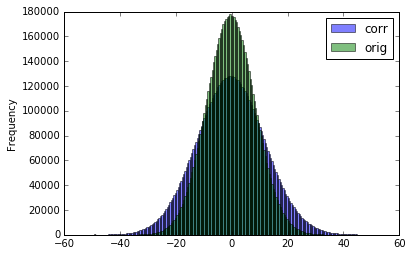

In [14]:
import scipy.stats

print 'UNCORRECTED:', dit.computeClippedAfwStats(im1.getMaskedImage())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2.getMaskedImage())
#print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)

im1a = im1.getMaskedImage().getImage()
im2a = im2.getMaskedImage().getImage()
im1a = im1a.getArray()[~(np.isnan(im1a.getArray())|np.isinf(im1a.getArray()))]
im2a = im2a.getArray()[~(np.isnan(im2a.getArray())|np.isinf(im2a.getArray()))]
im1a = im1a[im1a != 0.]
im2a = im2a[im2a != 0.]
im1a, _, _ = scipy.stats.sigmaclip(im1a)
im2a, _, _ = scipy.stats.sigmaclip(im2a)
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.349174543978
0.0759764731369


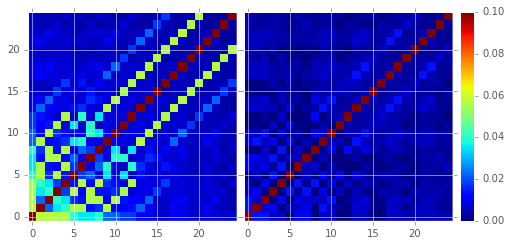

In [15]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im1a)
im1a[(im1a < low)|(im1a > upp)] = 0.
cov1 = dit.computePixelCovariance(im1a)

im2a = im2.getMaskedImage().getImage().getArray()
im2a[np.isnan(im2a)|np.isinf(im2a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im2a)
im2a[(im2a < low)|(im2a > upp)] = 0.
cov2 = dit.computePixelCovariance(im2a)

dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.16220999714
1.00014561851 1.0
(14, 14) (14, 15)


DescribeResult(nobs=841, minmax=(-0.0025075321056929681, 0.0055429439426502546), mean=1.7314923479046116e-07, variance=2.6730371985658876e-07, skewness=5.0032314047331825, kurtosis=48.184986228272074)

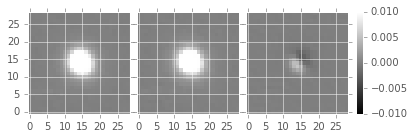

In [16]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance plane appears to be getting set too high in the corrected diffim...?
(130 vs. expected 123...?)

But I think this is too high because we are including the non-convolved pixels (around the edges) in the statistics.
Need to include the masks in the statistics.

SCIENCE: (62.84457659383536, 2.5404391536279887, 6.453831093286091)
TEMPLATE:   (60.06118391251214, 2.487510550604642, 6.187708739369411)
UNCORRECTED: (66.89930937449972, 2.534175418012832, 6.422045049260512)
CORRECTED:   (130.23210680730892, 4.919840582746153, 24.204831359636014)
EXPECTED:    122.905760506
7520808 7236304 8087169 8089345


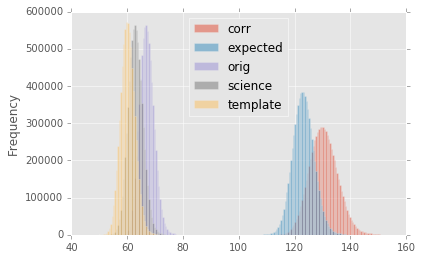

In [29]:
im1a = im1.getMaskedImage().getVariance()
im2a = im2.getMaskedImage().getVariance()
imsa = sciImg.getMaskedImage().getVariance()
imta = templImg.getMaskedImage().getVariance()

tmp = sciImg.getMaskedImage().clone()
tmp -= templImg.getMaskedImage()
tmp = tmp.getVariance()

print 'SCIENCE:', dit.computeClippedAfwStats(imsa)
print 'TEMPLATE:  ', dit.computeClippedAfwStats(imta)
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1a)
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2a)
print 'EXPECTED:   ', dit.computeClippedAfwStats(imsa)[0] + dit.computeClippedAfwStats(imta)[0]

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1a.getArray())
im2a = getClippedPixels(im2a.getArray())
imsa = getClippedPixels(imsa.getArray())
imta = getClippedPixels(imta.getArray())
tmp = getClippedPixels(tmp.getArray())
print len(im1a), len(im2a), len(imsa), len(imta)
im1a = im1a[:len(im2a)]
imsa = imsa[:len(im2a)]
imta = imta[:len(im2a)]
tmp = tmp[:len(im2a)]
expected = tmp

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a, 'science': imsa, 'template': imta, 'expected': expected})
df.plot.hist(alpha=0.5, bins=200)